# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Calibrate Q pixel size, no beam stop

This notebook calibrates the pixel size in the diffraction plane for data without a beam stop.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq

from py4DSTEM.file.io import read
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import get_dq, get_dq_from_indexed_peaks

In [2]:
# Get data

fp = "/media/AuxDriveB/Data/20191112_CalibrationSimulations/circular_probe/processing_polyAu.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    bvm_corrected                       DiffractionSlice    
   1    bvm_initial                         DiffractionSlice    
   2    bvm_shifted                         DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    bright_field_image                  RealSlice           
   5    diffraction_shifts                  RealSlice           
   6    ellipse_params                      PointList           
   7    invA_per_Qpixel                     PointList           
   8    braggpeaks_corrected                PointListArray      
   9    braggpeaks_initial                  PointListArray      
   10   braggpeaks_shifted                  PointListArray      


In [3]:
bvm = browser.get_dataobject('bvm_corrected').data
browser.close()

Q_Nx,Q_Ny = bvm.shape

### Calibration

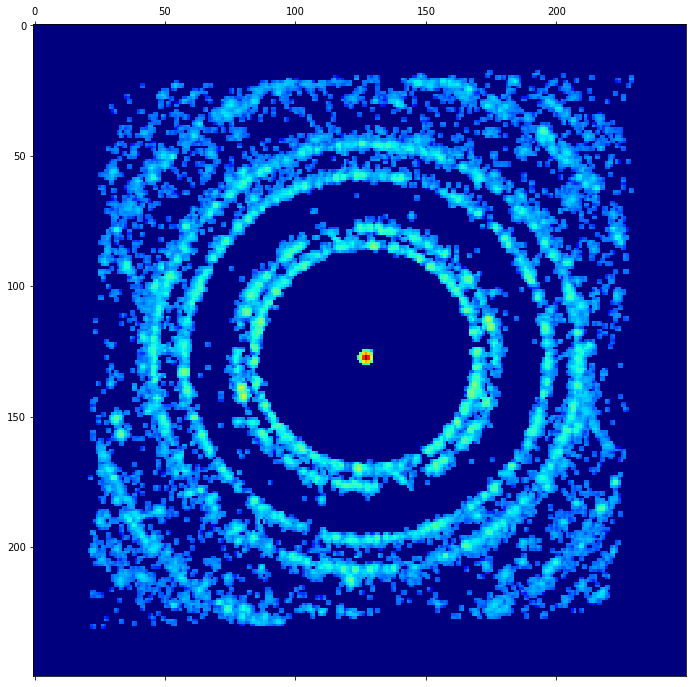

In [4]:
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm**0.1,cmap='jet')
plt.show()

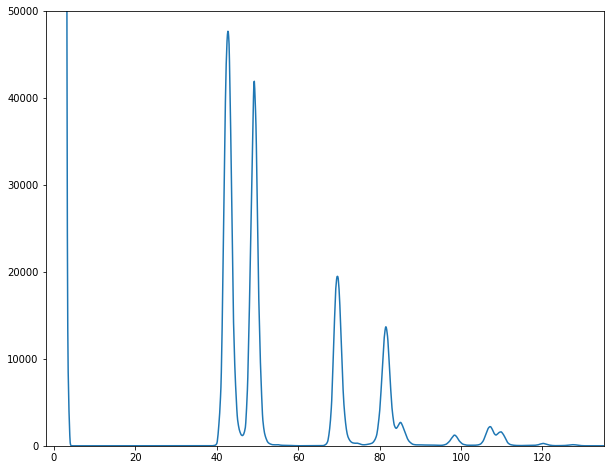

In [5]:
# Get radial profile

dr = 0.1

xmax=135
ymax=50000

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(bvm,2)),(Q_Nx,Q_Ny))
radial_profile,rbins = radial_integral(bvm,x0,y0,dr=dr)

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(rbins,radial_profile)
ax.set_xlim(-2,xmax)
ax.set_ylim(0,ymax)
plt.show()

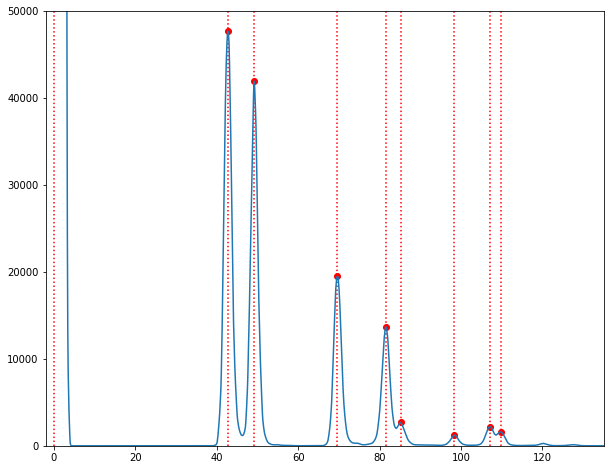

In [6]:
# Get radial profile maxima

sigma=0
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)
maxima_r,maxima_I = rbins[maxima],radial_profile[maxima]
inds = np.argsort(maxima_r)
maxima_r,maxima_I = maxima_r[inds],maxima_I[inds]

# Show
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(rbins,radial_profile)
ax.set_xlim(-2,xmax)
ax.set_ylim(0,ymax)
ax.scatter(maxima_r,maxima_I,color='r')
ax.vlines(maxima_r,0,ax.get_ylim()[1],color='r',ls=':')
plt.show()

#### Method 1: from a single measurement

Select and calibrate with a single peak for which we know the corresponding real space distance

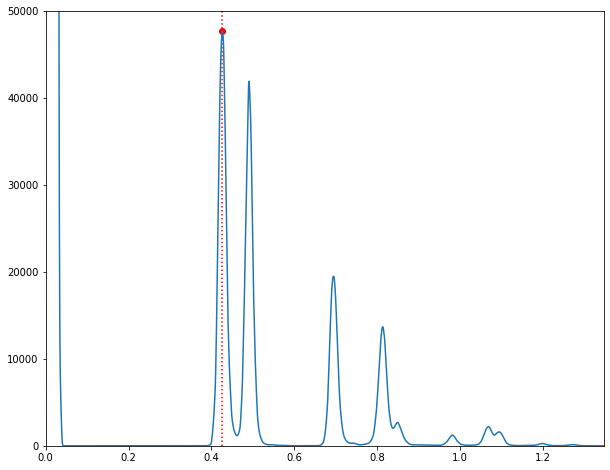

In [8]:
d_Angstroms = 2.347     # The gold 111 peak
peak_index = 1          # Choose a peak

dq_method1 = get_dq(maxima_r[peak_index],d_Angstroms)

# Show
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(rbins*dq_method1,radial_profile)
ax.set_xlim(0,xmax*dq_method1)
ax.set_ylim(0,ymax)
ax.scatter(maxima_r[peak_index]*dq_method1,maxima_I[peak_index],color='r')
ax.vlines(maxima_r[peak_index]*dq_method1,0,ax.get_ylim()[1],color='r',ls=':')
plt.show()

#### Method 2: using several peaks with known Miller indices

Specify the unit cell size, and the Miller indices.  Use (0,0,0) to ignore a peak.

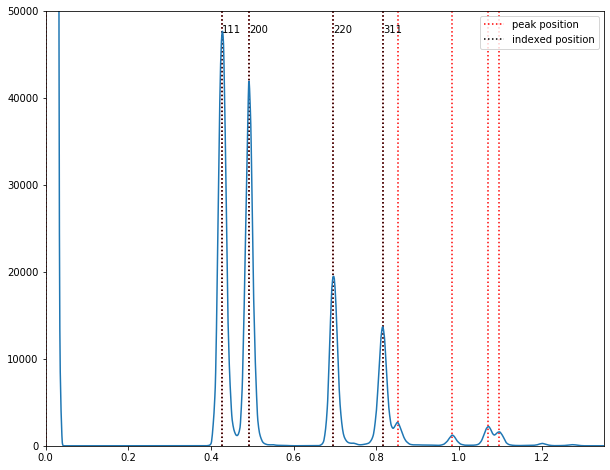

In [11]:
a_Angstroms = 4.065

hkl = [(0,0,0),
       (1,1,1),
       (2,0,0),
       (2,2,0),
       (3,1,1),
       (0,0,0),
       (0,0,0),
       (0,0,0),
       (0,0,0)]

# Calibrate detector pixel size
dq,qs_fit,hkl_fit = get_dq_from_indexed_peaks(maxima_r, hkl, a_Angstroms)
rbins_cal = rbins*dq

# Show
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(rbins_cal,radial_profile)
ax.set_xlim(0,dq*xmax)
ax.set_ylim(0,ymax)
ax.vlines(dq*maxima_r,0,ax.get_ylim()[1],color='r',ls=':',label='peak position')
ax.vlines(qs_fit,0,ax.get_ylim()[1],color='k',ls=':',label='indexed position')
for i,(h,k,l) in enumerate(hkl_fit):
    ax.text(qs_fit[i],0.95*(ax.get_ylim()[1]-ax.get_ylim()[0]),s='{}{}{}'.format(h,k,l),color='k')
ax.legend()
plt.show()